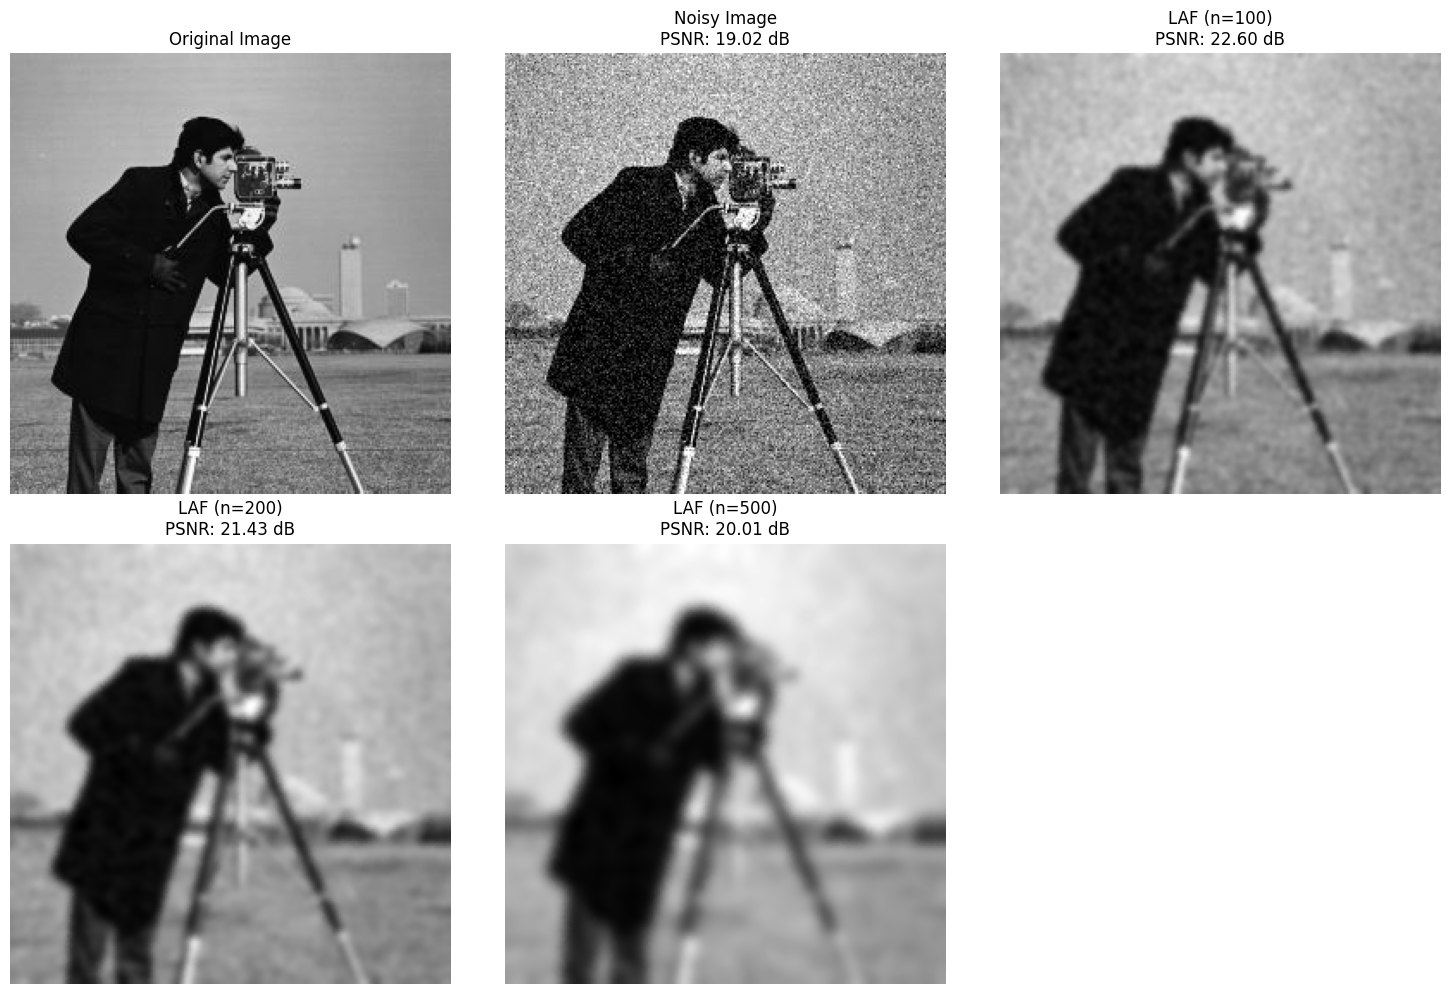

PSNR (Noisy): 19.02 dB
PSNR (n=100): 22.60 dB
PSNR (n=200): 21.43 dB
PSNR (n=500): 20.01 dB


In [2]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
from PIL import Image
from skimage import metrics
import warnings
warnings.filterwarnings("ignore")  # Suppress interpolation warnings

# Function to perform advection
def advect(image, u, v):
    h, w = image.shape
    x = np.arange(w)
    y = np.arange(h)
    interp = RegularGridInterpolator((y, x), image, method='linear', bounds_error=False, fill_value=0)
    
    # Create meshgrid for coordinates
    X, Y = np.meshgrid(x, y)
    # New coordinates after advection
    new_x = X - u
    new_y = Y - v
    # Clip coordinates to image bounds
    new_x = np.clip(new_x, 0, w-1)
    new_y = np.clip(new_y, 0, h-1)
    # Interpolate
    coords = np.stack((new_y, new_x), axis=-1)
    return interp(coords)

# Linear Advection Filter (LAF)
def LAF(image, n, tau0):
    result = image.copy()
    for _ in range(n):
        # Random angles for advection field
        theta = np.random.uniform(0, 2*np.pi, image.shape)
        u = np.cos(theta)
        v = np.sin(theta)
        # Scale advection field
        u_scaled = tau0 * u
        v_scaled = tau0 * v
        # Advect image
        result = advect(result, u_scaled, v_scaled)
    return result

# Load image
image_path = r"Input Image/original_cameraman.jpg"
try:
    image = np.array(Image.open(image_path).convert('L')).astype(np.float32) / 255.0  # Convert to grayscale and normalize
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    exit(1)

# Add Gaussian noise (sigma = 30/255 after normalization)
sigma = 30 / 255.0
noisy_image = image + np.random.normal(0, sigma, image.shape)
noisy_image = np.clip(noisy_image, 0, 1)

# Parameters
tau0 = 0.05
n_values = [100, 200, 500]

# Apply LAF for each n
filtered_images = {}
for n in n_values:
    filtered_images[n] = LAF(noisy_image, n, tau0)

# Calculate PSNR
psnr_noisy = metrics.peak_signal_noise_ratio(image, noisy_image, data_range=1.0)
psnr_filtered = {n: metrics.peak_signal_noise_ratio(image, filtered_images[n], data_range=1.0)
                 for n in n_values}

# Display results
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Noisy image
plt.subplot(2, 3, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title(f'Noisy Image\nPSNR: {psnr_noisy:.2f} dB')
plt.axis('off')

# Filtered images
for i, n in enumerate(n_values, 3):
    plt.subplot(2, 3, i)
    plt.imshow(filtered_images[n], cmap='gray')
    plt.title(f'LAF (n={n})\nPSNR: {psnr_filtered[n]:.2f} dB')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print PSNR values
print(f"PSNR (Noisy): {psnr_noisy:.2f} dB")
for n in n_values:
    print(f"PSNR (n={n}): {psnr_filtered[n]:.2f} dB")